# Codigo base

In [1]:
library(lpirfs)
library(gridExtra)
library(ggplot2)
library(readxl)
library(httr)

library(reshape2)
library(purrr) 

In [40]:
run_lp_model <- function(data, endog, exog, max_lags, newey_lags = NULL, horizons = 10, signif, lags_exog = NULL, cumulative = FALSE) {
  # Map confidence levels to the corresponding values
  confint_map <- c("0.05" = 1.96, "0.32" = 1)

  # Check if the provided significance level is valid
  if (!as.character(signif) %in% names(confint_map)) {
    stop("Invalid significance level. Use 0.05 for 95% or 0.32 for 68%.")
  }

  if (!is.null(exog)) {
    exog_data <- data[, exog, drop = FALSE]
    if (is.null(lags_exog)) {
        lags_exog = max_lags
    }
  } else {
    exog_data = NULL
  }

  # Select endogenous variables
  endog_data <- data[, endog, drop = FALSE]
  
  # Convert to numeric (ensure proper model fitting)
  endog_data <- data.frame(lapply(endog_data, as.numeric))
  
  # Run the local projections model
  results_lin <- lp_lin(
    endog_data, 
    exog_data = exog_data,
    lags_endog_lin = max_lags,  
    trend          = 0,  
    shock_type     = 1,  
    confint        = confint_map[as.character(signif)], 
    nw_lag         = newey_lags,
    hor            = horizons,
    lags_exog = lags_exog
  )

  title_text <- paste0(
    "LocalProjection ", 
    if (!is.null(exog)) "(with exog)" else "(without exog)", 
    if (cumulative) " - Cumulative" else "",
    " - signif ", 1-signif
  )

  if (cumulative) {
    for (i in 1:dim(results_lin$irf_lin_mean)[3]) {
      # Cumsum mean IRFs
      results_lin$irf_lin_mean[,,i] <- t(apply(results_lin$irf_lin_mean[,,i], 1, cumsum))
      
      # Cumsum error bands to match cumulative mean
      results_lin$irf_lin_low[,,i] <- t(apply(results_lin$irf_lin_low[,,i], 1, cumsum))
      results_lin$irf_lin_up[,,i]  <- t(apply(results_lin$irf_lin_up[,,i], 1, cumsum))
    }
  }

  plotlp(results_lin, endog = endog, title_text = title_text)
  
  # Process and print results with cumulative option
  pretty_results(results_lin = results_lin, endog_vars = endog)

  return(results_lin)
}

plotlp <- function(results_lin, endog, title_text) {
  # Generate plots
  linear_plots <- plot_lin(results_lin)

  print(title_text)
  
  # Show all plots
  lin_plots_all <- sapply(linear_plots, ggplotGrob)

  final_plot <- marrangeGrob(lin_plots_all, nrow = length(endog), ncol = length(endog), 
                             top = grid::textGrob(title_text, gp = grid::gpar(fontsize = 14, fontface = "bold")))

  print(final_plot)
}

pretty_results <- function(results_lin, endog_vars) {
  # Extract IRF values, lower and upper bounds
  irf_array <- results_lin$irf_lin_mean
  lower_bound_array <- results_lin$irf_lin_low
  upper_bound_array <- results_lin$irf_lin_up

  # Get dimensions
  dims <- dim(irf_array)
  n_endog <- dims[1]  # Number of endogenous variables (responses)
  n_horizons <- dims[2]  # Number of horizons
  n_impulses <- dims[3]  # Number of impulses

  # Ensure the array is flattened correctly
  irf_values <- as.vector(aperm(irf_array, c(3, 1, 2)))  # Reorder to match impulse-response-horizon
  lower_values <- as.vector(aperm(lower_bound_array, c(3, 1, 2)))
  upper_values <- as.vector(aperm(upper_bound_array, c(3, 1, 2)))

  # Create index grid with correctly ordered impulse, response, and horizon
  indices <- expand.grid(
    impulse = 1:n_impulses,  # third dimension
    response = 1:n_endog,    # first dimension
    horizon = 1:n_horizons   # second dimension
  )

  # Create the data frame with corrected order
  irf_df <- data.frame(
    indices,
    irf_value = irf_values,
    lower_bound = lower_values,
    upper_bound = upper_values
  )


  # Exclude rows where impulse == response
  irf_df <- subset(irf_df, impulse != response)

  # Order by impulse, response, then horizon
  irf_df <- irf_df[order(irf_df$impulse, irf_df$response, irf_df$horizon), ]

  # Remove row names (drop index numbers)
  row.names(irf_df) <- NULL

  irf_df <- as.data.frame(irf_df)

  # Map impulse and response numbers to names
  irf_named_df <- irf_df
  irf_named_df$impulse <- endog_vars[irf_named_df$impulse]
  irf_named_df$response <- endog_vars[irf_named_df$response]

  # Split into a list of dataframes by impulse-response pair
  irf_list <- split(irf_named_df, list(irf_named_df$impulse, irf_named_df$response), drop = TRUE)

  # Print all dataframes in the list
  lapply(irf_list, print)
  return(irf_named_df)
}

makeLogColumns <- function(lista, data) {
  df <- data  # Make a copy of the data frame
  for (c in lista) {
    df[[c]] <- log(as.numeric(df[[c]]))  # Convert to numeric and take log
  }
  return(df)
}

makeDiffColumns <- function(lista, data, factor = 1, drop = TRUE) {
  df <- data  # Make a copy of the data frame
  for (c in lista) {
    df[[c]] <- c(rep(NA, factor), diff(df[[c]], differences = factor))  # Compute differences
  }
  if (drop) {
    df <- df[(factor + 1):nrow(df), , drop = FALSE]  # Drop first `factor` rows
  }
  return(df)
}

renameColumnOfDataframe <- function(dataframe, oldColumnName, newColumnName) {
  df <- dataframe  # Make a copy of the dataframe
  colnames(df)[colnames(df) == oldColumnName] <- newColumnName  # Rename column
  return(df)
}


# Cargar datos

In [30]:
# Example of how to call the function
url <- "https://github.com/mbarrena/tesis/raw/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx"
temp_file <- tempfile(fileext = ".xlsx")
GET(url, write_disk(temp_file, overwrite = TRUE))

# Read the `data` from the Excel file
df_trimestral_crudo <- read_excel(temp_file)

Response [https://raw.githubusercontent.com/mbarrena/tesis/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx]
  Date: 2025-03-23 21:48
  Status: 200
  Content-Type: application/octet-stream
  Size: 57.9 kB
<ON DISK>  /var/folders/59/6k0yx0n916gg1mdb04zs42rm0000gn/T//Rtmp6zmY0f/file839931c7afe7.xlsxNULL

In [41]:
# Select specific columns and rows from df_trimestral_crudo
df_Arg <- df_trimestral_crudo |> 
  dplyr::slice(37:dplyr::n()) |>  # Equivalent to iloc[36:] (1-based index in R)
  dplyr::select(año, trimestre, ipc_ajust, E, Ebc, pbird, impp_usa, Psoja_USA, Pmaíz_USA, Ptrigo_USA, TOTfmi) |>  # nolint
  as.data.frame()  # Convert to data frame (if needed)

# Rename "ipc_ajust" to "ipc"
df_Arg <- renameColumnOfDataframe(df_Arg, "ipc_ajust", "ipc")

# Display first 6 rows
print(head(df_Arg))

# Display first 65 rows
print(head(df_Arg, 65))

   año trimestre          ipc            E          Ebc  pbird impp_usa
1 1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2 1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.25134
3 1959      3ºTr 3.511185e-11 8.408333e-12 8.414333e-12 166259 13.27944
4 1959      4ºTr 3.704045e-11 8.313333e-12 8.275667e-12 178163 13.47618
5 1960      1ºTr 3.935256e-11 8.293333e-12 8.297333e-12 186316 13.50428
6 1960      2ºTr 3.948672e-11 8.300000e-12 8.313000e-12 187541 13.51833
  Psoja_USA Pmaíz_USA Ptrigo_USA TOTfmi
1  2.046667 1.0433333   1.736667     NA
2  2.106667 1.1500000   1.743333     NA
3  1.976667 1.1166667   1.723333     NA
4  1.970000 0.9856667   1.780000     NA
5  1.996667 1.0096667   1.800000     NA
6  1.996667 1.0766667   1.786667     NA


    año trimestre          ipc            E          Ebc  pbird impp_usa
1  1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2  1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.25134
3  1959      3ºTr 3.511185e-11 8.408333e-12 8.414333e-12 166259 13.27944
4  1959      4ºTr 3.704045e-11 8.313333e-12 8.275667e-12 178163 13.47618
5  1960      1ºTr 3.935256e-11 8.293333e-12 8.297333e-12 186316 13.50428
6  1960      2ºTr 3.948672e-11 8.300000e-12 8.313000e-12 187541 13.51833
7  1960      3ºTr 3.983516e-11 8.282667e-12 8.278667e-12 190377 13.53239
8  1960      4ºTr 4.218076e-11 8.280000e-12 8.287333e-12 195894 13.37781
9  1961      1ºTr 4.281077e-11 8.271667e-12 8.272667e-12 200750 13.33565
10 1961      2ºTr 4.468719e-11 8.275667e-12 8.284000e-12 203172 13.29350
11 1961      3ºTr 4.628223e-11 8.291667e-12 8.278667e-12 206637 13.29350
12 1961      4ºTr 4.915058e-11 8.303333e-12 8.297000e-12 203716 13.27944
13 1962      1ºTr 5.109406e-11 8.301333e-12 8.29466

In [42]:
# Copy df_Arg to df_ERPT_Arg1
df_ERPT_Arg1 <- df_Arg

# Display first rows
print(head(df_ERPT_Arg1))

# Apply logarithm to specific columns
df_ERPT_Arg1 <- makeLogColumns(c("ipc", "E", "Ebc", "pbird", "impp_usa", "Psoja_USA", "Pmaíz_USA", "Ptrigo_USA", "TOTfmi"), df_ERPT_Arg1) # nolint: line_length_linter.

# Display transformed dataframe
print(head(df_ERPT_Arg1))
print(tail(df_ERPT_Arg1))

   año trimestre          ipc            E          Ebc  pbird impp_usa
1 1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2 1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.25134
3 1959      3ºTr 3.511185e-11 8.408333e-12 8.414333e-12 166259 13.27944
4 1959      4ºTr 3.704045e-11 8.313333e-12 8.275667e-12 178163 13.47618
5 1960      1ºTr 3.935256e-11 8.293333e-12 8.297333e-12 186316 13.50428
6 1960      2ºTr 3.948672e-11 8.300000e-12 8.313000e-12 187541 13.51833
  Psoja_USA Pmaíz_USA Ptrigo_USA TOTfmi
1  2.046667 1.0433333   1.736667     NA
2  2.106667 1.1500000   1.743333     NA
3  1.976667 1.1166667   1.723333     NA
4  1.970000 0.9856667   1.780000     NA
5  1.996667 1.0096667   1.800000     NA
6  1.996667 1.0766667   1.786667     NA
   año trimestre       ipc         E       Ebc    pbird impp_usa Psoja_USA
1 1959      1ºTr -24.44751 -25.73041 -25.73350 12.08546 2.583038 0.7162125
2 1959      2ºTr -24.20521 -25.48431 -25.51272 12.11605 2.584099 0

In [43]:
# Create df_ERPT_Arg as a copy of df_Arg
df_ERPT_Arg <- df_Arg

# Display first rows
print(head(df_ERPT_Arg))

# Apply logarithm transformation
df_ERPT_Arg <- makeLogColumns(c("ipc", "E", "Ebc", "pbird", "impp_usa", "Psoja_USA", "Pmaíz_USA", "Ptrigo_USA", "TOTfmi"), df_ERPT_Arg)

# Display transformed dataframe
print(head(df_ERPT_Arg))

# Apply differencing transformation
df_ERPT_Arg <- makeDiffColumns(c("ipc", "E", "Ebc", "pbird", "impp_usa", "Psoja_USA", "Pmaíz_USA", "Ptrigo_USA", "TOTfmi"), df_ERPT_Arg)

# Display first and last rows
print(head(df_ERPT_Arg))
print(tail(df_ERPT_Arg, 90))

   año trimestre          ipc            E          Ebc  pbird impp_usa
1 1959      1ºTr 2.413144e-11 6.690000e-12 6.669333e-12 177276 13.23729
2 1959      2ºTr 3.074744e-11 8.556667e-12 8.317000e-12 182783 13.25134
3 1959      3ºTr 3.511185e-11 8.408333e-12 8.414333e-12 166259 13.27944
4 1959      4ºTr 3.704045e-11 8.313333e-12 8.275667e-12 178163 13.47618
5 1960      1ºTr 3.935256e-11 8.293333e-12 8.297333e-12 186316 13.50428
6 1960      2ºTr 3.948672e-11 8.300000e-12 8.313000e-12 187541 13.51833
  Psoja_USA Pmaíz_USA Ptrigo_USA TOTfmi
1  2.046667 1.0433333   1.736667     NA
2  2.106667 1.1500000   1.743333     NA
3  1.976667 1.1166667   1.723333     NA
4  1.970000 0.9856667   1.780000     NA
5  1.996667 1.0096667   1.800000     NA
6  1.996667 1.0766667   1.786667     NA
   año trimestre       ipc         E       Ebc    pbird impp_usa Psoja_USA
1 1959      1ºTr -24.44751 -25.73041 -25.73350 12.08546 2.583038 0.7162125
2 1959      2ºTr -24.20521 -25.48431 -25.51272 12.11605 2.584099 0

# Regresiones

[1] "LocalProjection (with exog) - signif 0.95"
   impulse response horizon   irf_value lower_bound upper_bound
23     ipc        E       1  0.00000000  0.00000000  0.00000000
24     ipc        E       2 -0.37009325 -0.79228778  0.05210129
25     ipc        E       3  0.17010576 -0.15969957  0.49991109
26     ipc        E       4  0.42525623 -0.02379667  0.87430913
27     ipc        E       5  0.42662959 -0.13704435  0.99030353
28     ipc        E       6 -0.15732090 -0.49974786  0.18510607
29     ipc        E       7  0.16373951 -0.15548121  0.48296023
30     ipc        E       8  0.07922268 -0.29699831  0.45544368
31     ipc        E       9 -0.15646354 -0.39660486  0.08367778
32     ipc        E      10 -0.11641602 -0.40454450  0.17171246
33     ipc        E      11 -0.08064676 -0.41541555  0.25412203
   impulse response horizon   irf_value lower_bound upper_bound
45   pbird        E       1  0.00000000   0.0000000   0.0000000
46   pbird        E       2 -0.95580422  -2.0520550   0.

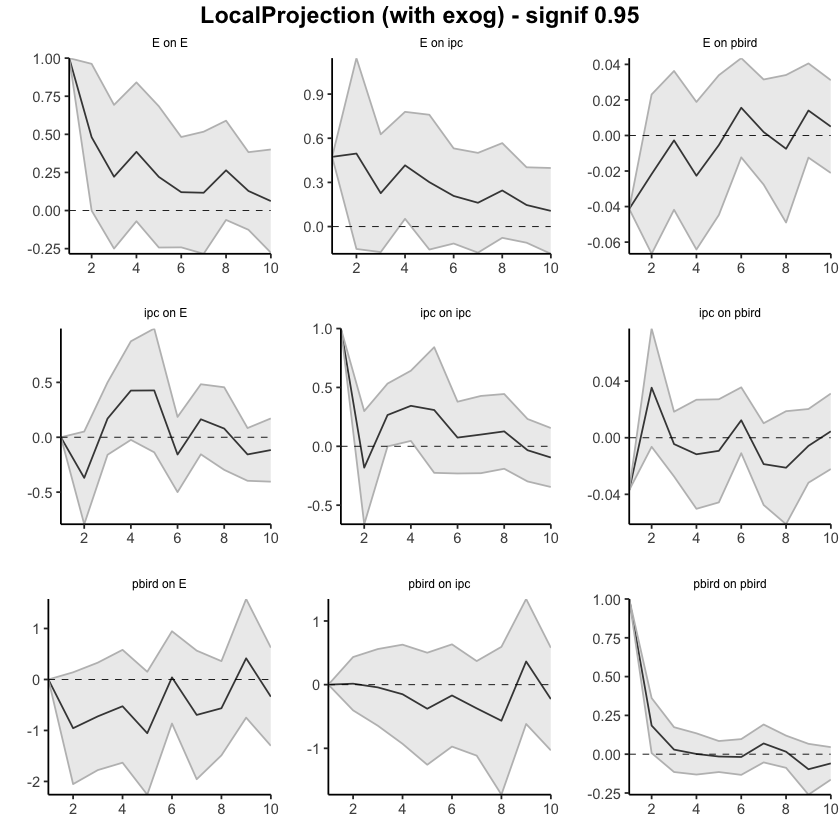

In [47]:
res <- run_lp_model(df_ERPT_Arg, endog=c("E", "ipc", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.05)

[1] "LocalProjection (with exog) - Cumulative - signif 0.95"
   impulse response horizon  irf_value lower_bound upper_bound
23     ipc        E       1  0.0000000   0.0000000  0.00000000
24     ipc        E       2 -0.3700932  -0.7922878  0.05210129
25     ipc        E       3 -0.1999875  -0.9519873  0.55201238
26     ipc        E       4  0.2252687  -0.9757840  1.42632151
27     ipc        E       5  0.6518983  -1.1128284  2.41662505
28     ipc        E       6  0.4945774  -1.6125762  2.60173112
29     ipc        E       7  0.6583170  -1.7680574  3.08469135
30     ipc        E       8  0.7375396  -2.0650557  3.54013502
31     ipc        E       9  0.5810761  -2.4616606  3.62381280
32     ipc        E      10  0.4646601  -2.8662051  3.79552526
33     ipc        E      11  0.3840133  -3.2816207  4.04964728
   impulse response horizon  irf_value lower_bound upper_bound
45   pbird        E       1  0.0000000    0.000000   0.0000000
46   pbird        E       2 -0.9558042   -2.052055   0.14

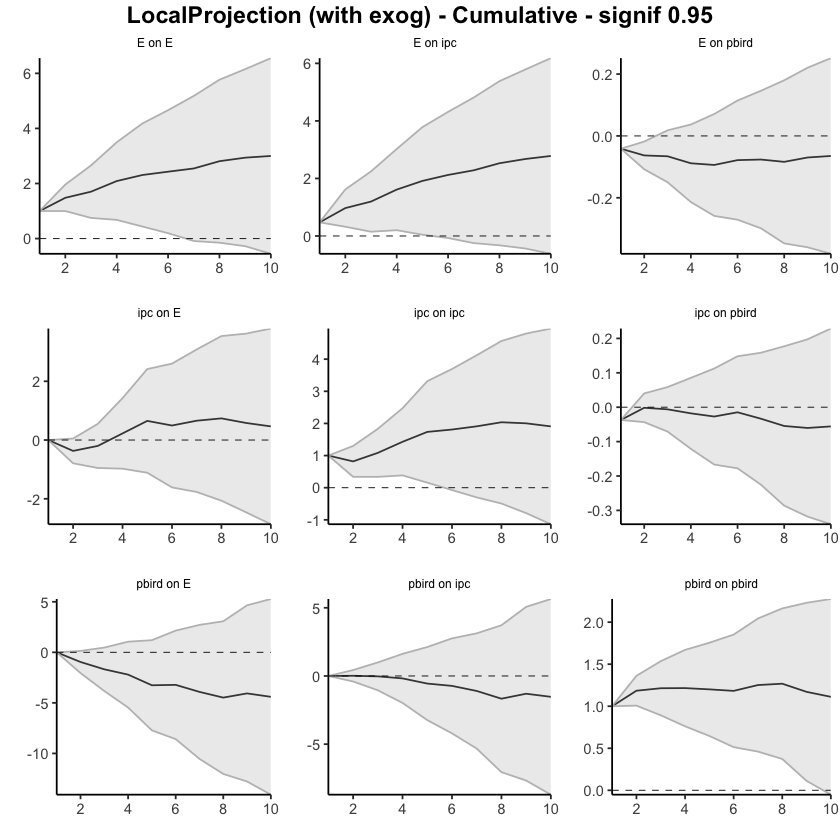

In [36]:
res <- run_lp_model(df_ERPT_Arg, endog=c("E", "ipc", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.05, cumulative=TRUE)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.32)

In [49]:
validate_pretty_results <- function(results_lin, endog_vars) {
  irf_array <- results_lin$irf_lin_mean

  # Select a test case
  test_impulse <- 2  # Example fixed index (adjustable)
  test_response <- 1
  test_horizon <- 6

  # Expected value from original array
  expected_value <- irf_array[test_response, test_horizon, test_impulse]

  # Run pretty_results and extract the full data frame
  irf_df <- pretty_results(results_lin, endog_vars)

  # Ensure impulse and response columns are character for comparison
  irf_df$impulse <- as.character(irf_df$impulse)
  irf_df$response <- as.character(irf_df$response)

  # Convert `endog_vars[test_impulse]` and `endog_vars[test_response]` to character for matching
  test_impulse_name <- as.character(endog_vars[test_impulse])
  test_response_name <- as.character(endog_vars[test_response])

  # Extract matching row
  matched_row <- subset(irf_df, 
                        impulse == test_impulse_name & 
                        response == test_response_name & 
                        horizon == test_horizon)

  # Print results
  print(paste("Expected IRF Value:", expected_value))

  # Ensure there's at least one match before printing
  if (nrow(matched_row) == 1) {
    print(paste("Extracted IRF Value:", matched_row$irf_value))

    if (round(expected_value, 6) == round(matched_row$irf_value, 6)) {
      print("✅ Validation passed!")
    } else {
      print("❌ Validation failed!")
    }
  } else {
    print("❌ No matching row found!")
  }
}

# Run validation
validate_pretty_results(res, c("E", "ipc", "pbird"))


   impulse response horizon   irf_value lower_bound upper_bound
23     ipc        E       1  0.00000000  0.00000000  0.00000000
24     ipc        E       2 -0.37009325 -0.79228778  0.05210129
25     ipc        E       3  0.17010576 -0.15969957  0.49991109
26     ipc        E       4  0.42525623 -0.02379667  0.87430913
27     ipc        E       5  0.42662959 -0.13704435  0.99030353
28     ipc        E       6 -0.15732090 -0.49974786  0.18510607
29     ipc        E       7  0.16373951 -0.15548121  0.48296023
30     ipc        E       8  0.07922268 -0.29699831  0.45544368
31     ipc        E       9 -0.15646354 -0.39660486  0.08367778
32     ipc        E      10 -0.11641602 -0.40454450  0.17171246
33     ipc        E      11 -0.08064676 -0.41541555  0.25412203
   impulse response horizon   irf_value lower_bound upper_bound
45   pbird        E       1  0.00000000   0.0000000   0.0000000
46   pbird        E       2 -0.95580422  -2.0520550   0.1404465
47   pbird        E       3 -0.72333711 

In [10]:
res <- run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 5, signif = 0.05)

ERROR: Error in data[, exog, drop = FALSE]: object of type 'closure' is not subsettable


[1] "LocalProjection (with exog) - Cumulative - signif 0.95"
     impulse response horizon irf_value lower_bound upper_bound
23 ipc_ajust        E       1  31.87134    31.87134    31.87134
24 ipc_ajust        E       2 179.89501    65.70833   294.08169
25 ipc_ajust        E       3 557.41018   269.60235   845.21801
26 ipc_ajust        E       4 555.18029  -179.72758  1290.08816
27 ipc_ajust        E       5 556.75536  -178.97983  1292.49056
28 ipc_ajust        E       6 558.27472  -180.12903  1296.67847
29 ipc_ajust        E       7 585.16519  -156.96324  1327.29362
30 ipc_ajust        E       8 605.94158  -146.49996  1358.38312
31 ipc_ajust        E       9 605.94158  -146.50120  1358.38436
32 ipc_ajust        E      10 605.94328  -146.50153  1358.38809
33 ipc_ajust        E      11 605.94376  -146.50542  1358.39295
   impulse response horizon   irf_value lower_bound upper_bound
45   pbird        E       1    266.8364    266.8364    266.8364
46   pbird        E       2  -1816.9617 -14

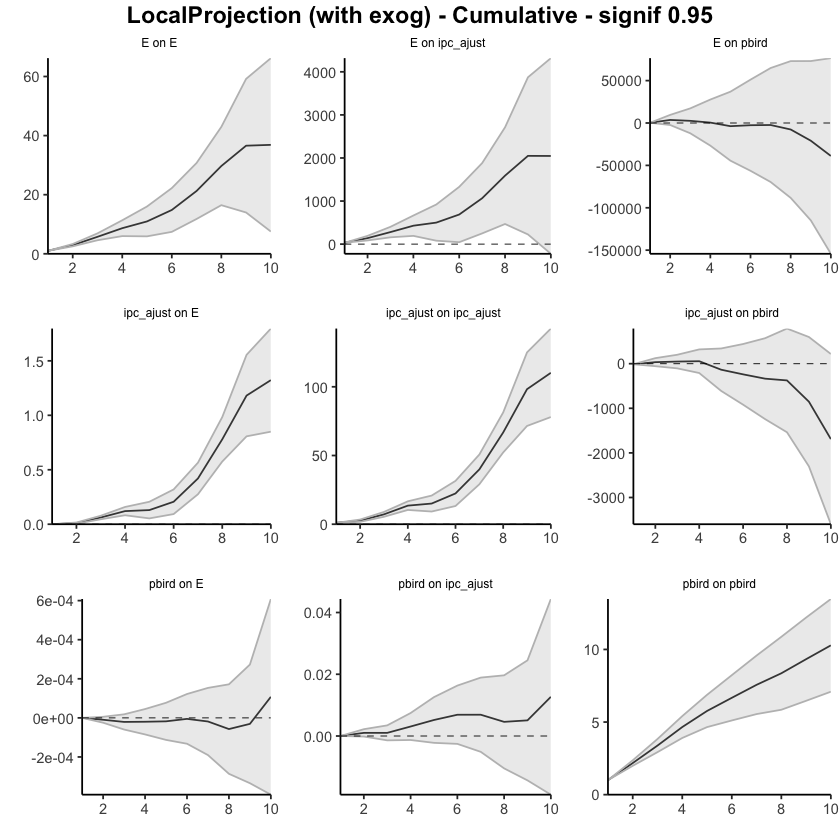

In [ ]:
res <- run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 5, signif = 0.05, cumulative=TRUE)